In [7]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

**November 2018**

Reporter: Stefan Helte

Vi vispade ihop en klassiker till förstauppslaget i nr 40 2018. Överbeläggnignarna inom svensk sjukvård. Data kommer från SKL:s [Väntetider i vården](https://www.vantetider.se/Kontaktkort/Sveriges/Overbelaggning/). Resultatet finns att läsa [i den här artikeln](https://dagenssamhalle.se/nyhet/platsbristen-okar-i-sjukvarden-24836).

In [8]:
df = pd.read_excel('data/överbeläggningar.xlsx',header=5)

In [9]:
df.columns

df.rename(columns={'Landsting / region':'landsting'},inplace=True)

df.columns = df.columns.str.lower().str.replace(" ","_")

df=df.sort_values('månad')

In [10]:
alla = df.loc[df['landsting']=='Alla landsting']

In [11]:
alla.dtypes

landsting                           object
överbeläggning                     float64
utlokaliserade_patienter           float64
månad                       datetime64[ns]
dtype: object

In [12]:
alla.drop('landsting',axis=1,inplace=True)

In [13]:
alla=alla.reset_index(drop=True)

In [14]:
import datetime

In [15]:
alla.rename(columns={'månad':'date'},inplace=True)

In [16]:
alla['månad'] = alla.date.apply(lambda x: x.strftime('%m'))

In [17]:
alla['år'] = alla.date.apply(lambda x: x.strftime('%Y'))

In [18]:
månader = {
    '01':'Januari',
    '02':'Februari',
    '03':'Mars',
    '04':'April',
    '05':'Maj',
    '06':'Juni',
    '07':'Juli',
    '08':'Augusti',
    '09':'September',
    '10':'Oktober',
    '11':'November',
    '12':'December'
}

In [19]:
alla.månad=alla.månad.map(månader)

In [20]:
alla.head()

,överbeläggning,utlokaliserade_patienter,date,månad,år
0,2.9,1.6,2013-01-01,Januari,2013
1,2.5,1.6,2013-02-01,Februari,2013
2,2.9,1.4,2013-03-01,Mars,2013
3,2.8,1.5,2013-04-01,April,2013
4,2.3,1.2,2013-05-01,Maj,2013


In [21]:
alla['år_månad'] = alla['månad'] + '_' + alla['år']

In [22]:
dfs = []
for month in alla.månad.unique():
    dfs.append(alla.loc[alla['månad']==month,['år','överbeläggning','månad']])

In [23]:
alla.dtypes

överbeläggning                     float64
utlokaliserade_patienter           float64
date                        datetime64[ns]
månad                               object
år                                  object
år_månad                            object
dtype: object

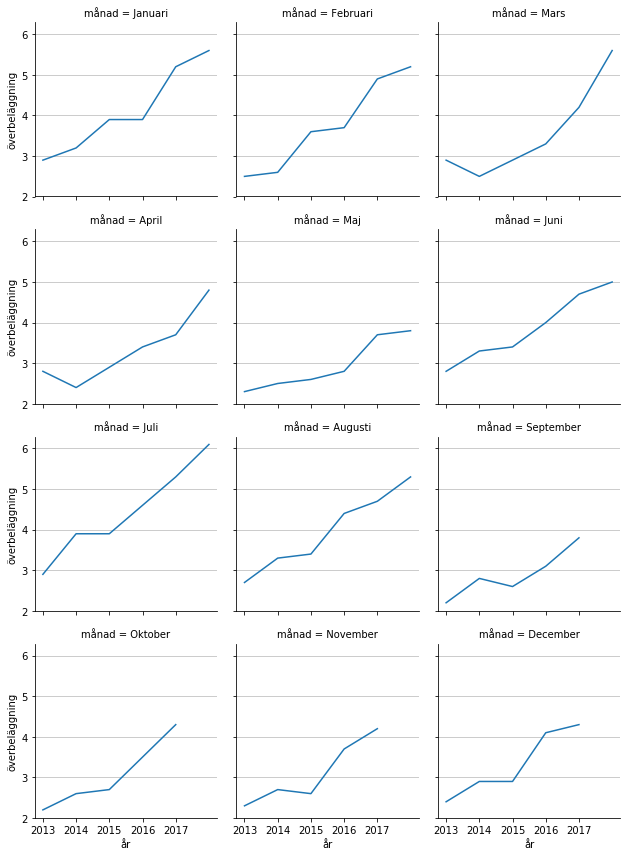

In [24]:
g = sns.FacetGrid(alla,col='månad',col_wrap=3)
g.map(plt.plot,'år','överbeläggning')

for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')

In [25]:
for year in alla.år.unique():
    alla.loc[alla['år']==year,'medel'] = alla.loc[alla['år']==year,'överbeläggning'].mean()

In [26]:
alla.år = alla.år.astype('int')

In [27]:
os.makedirs('res')

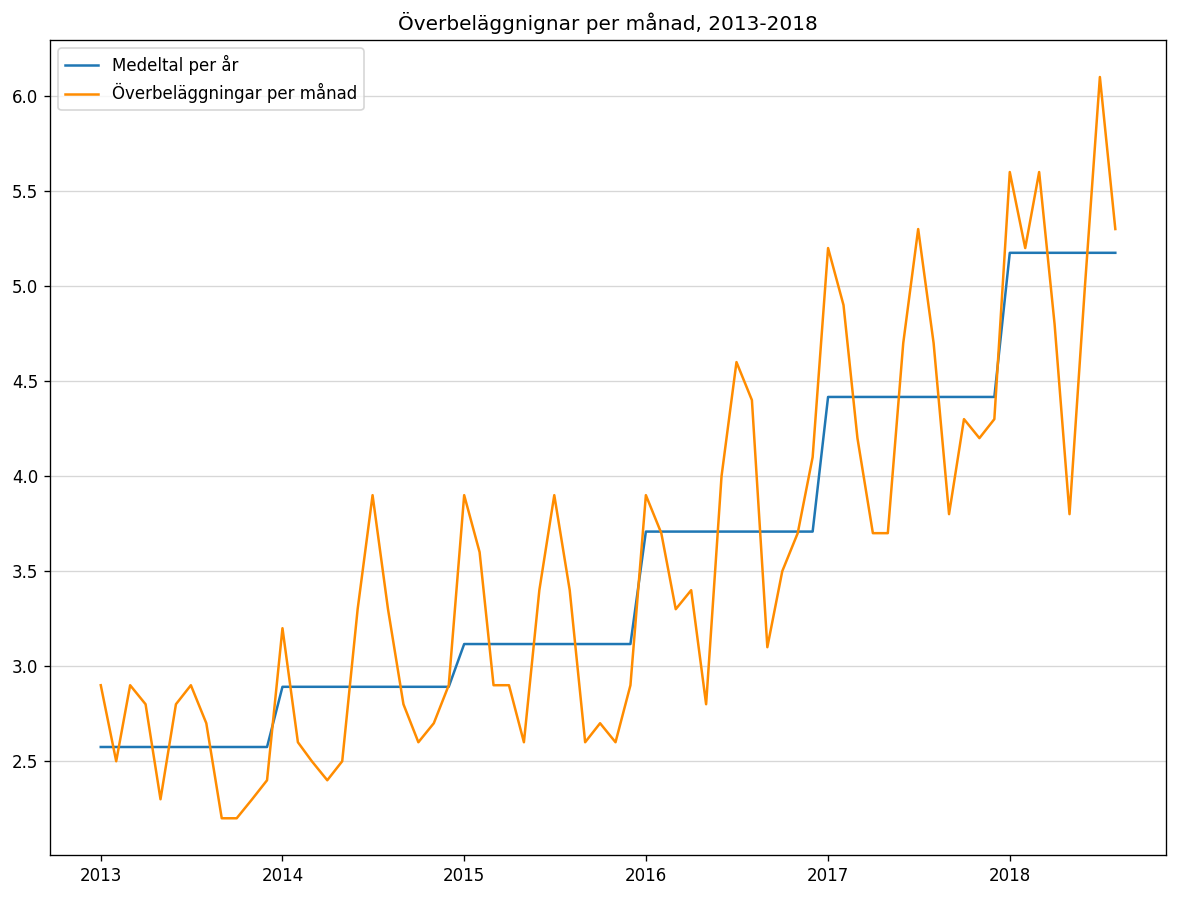

In [28]:
fig,ax = plt.subplots(figsize=(12,9),dpi=120)

ax.plot(alla['date'], alla['medel'],label='Medeltal per år')
ax.plot(alla['date'], alla['överbeläggning'], "#FF8C00",label='Överbeläggningar per månad')
ax.grid(True,axis='y',alpha=0.5)
plt.legend()
plt.title("Överbeläggnignar per månad, 2013-2018")
plt.savefig('res/alla_månader.png')


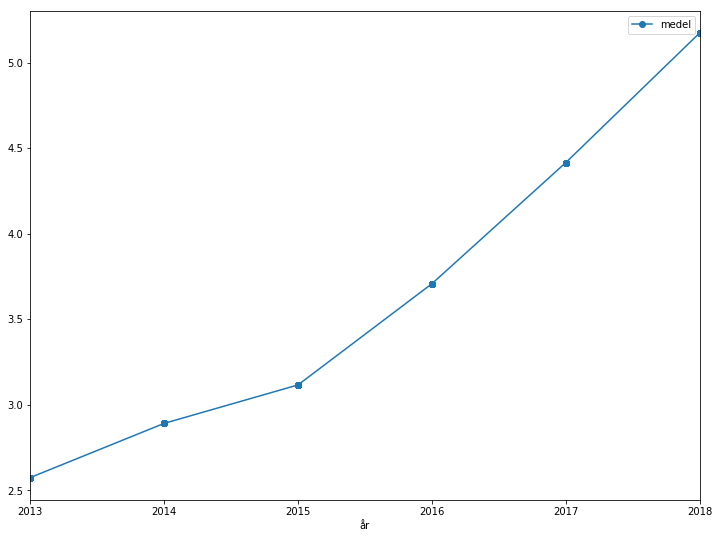

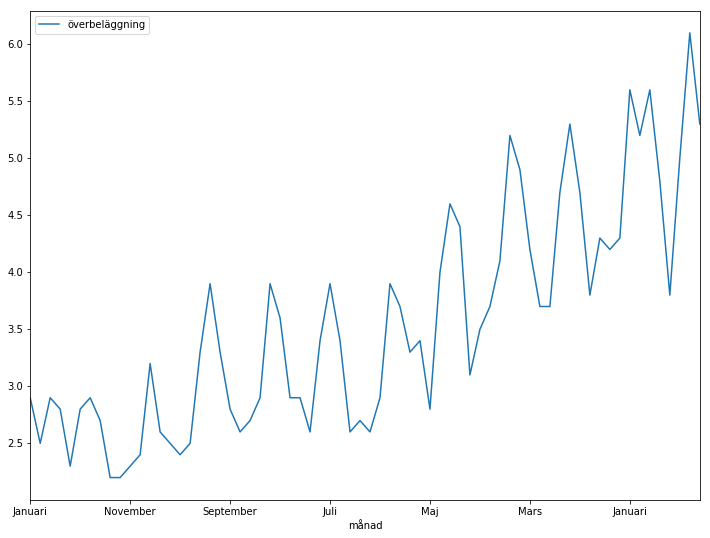

In [29]:
alla[['år','medel']].plot(x='år',y='medel',marker='o',figsize=(12,9))
#ax = fig.add_axes()
#ax.plot()
alla[['månad','överbeläggning']].plot(x='månad',y='överbeläggning',figsize=(12,9))

In [30]:
jämförelsemånader = ['Januari', 'Februari', 'Mars', 'April', 'Maj', 'Juni', 'Juli', 'Augusti']

För att kunna jämföra årsmedel med hittills 2018 stryker vi alla månader per år som inte finns med i data för 2018, dvs september, oktober, november och december:

In [31]:
årsjämförelser = alla.loc[alla['månad'].isin(jämförelsemånader)]

In [32]:
for year in årsjämförelser.år.unique():
    årsjämförelser.loc[årsjämförelser['år']==year,'medel'] = årsjämförelser.loc[årsjämförelser['år']==year,'överbeläggning'].mean()

In [33]:
sammanfattning = årsjämförelser[['år','medel']].drop_duplicates()

In [34]:
sammanfattning

,år,medel
0,2013,2.7250
12,2014,2.9625
24,2015,3.3250
36,2016,3.7625
48,2017,4.5500
60,2018,5.1750


In [35]:
(((sammanfattning.iloc[-1,1]-sammanfattning.iloc[-2,1])/sammanfattning.iloc[-2,1])*100).round(1)

13.7

In [36]:
sammanfattning=sammanfattning.sort_values('år',ascending=False)

In [37]:
år = sammanfattning.år.tolist()[:-1]
ökning = []
for year in sammanfattning.år:
    if year != 2013:
        ökning.append((((sammanfattning.loc[sammanfattning['år']==year,'medel'].iloc[0]\
        / sammanfattning.loc[sammanfattning['år']==year-1,'medel'].iloc[0])-1)*100).round(1))
    else:
        break

In [38]:
pd.DataFrame(index=år,data=ökning).rename(columns={0:'Ökning i procent jämfört året innan'}).reset_index()

,index,Ökning i procent jämfört året innan
0,2018,13.7
1,2017,20.9
2,2016,13.2
3,2015,12.2
4,2014,8.7


In [39]:
sammanfattning.reset_index()

,index,år,medel
0,60,2018,5.1750
1,48,2017,4.5500
2,36,2016,3.7625
3,24,2015,3.3250
4,12,2014,2.9625
5,0,2013,2.7250


In [40]:
sammanfattning = sammanfattning.reset_index(drop=True).merge(pd.DataFrame(index=år,data=ökning)\
                                                            .reset_index()\
                                                            .rename(columns={0:'Ökning i procent jämfört året innan','index':'år'}),
                                                           on='år',
                                                           how='left')

In [41]:
sammanfattning.to_excel('res/sammanfattning_2013_2018.xlsx',index=False)

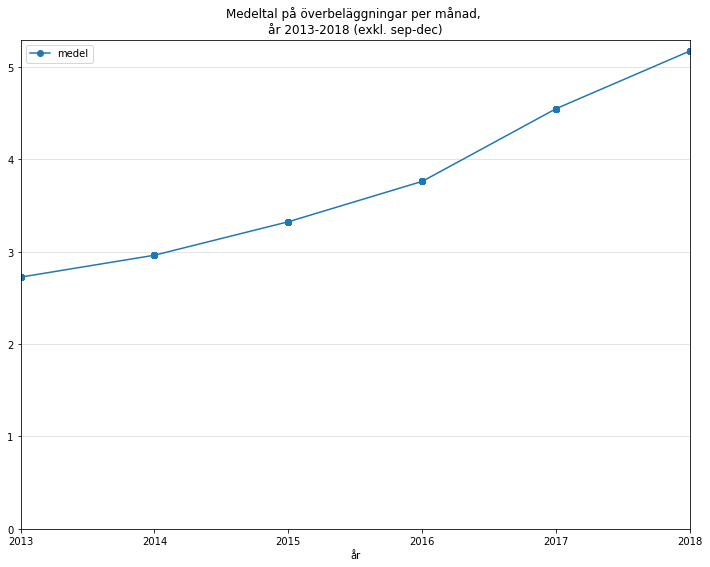

In [42]:
årsjämförelser[['år','medel']].plot(x='år',y='medel',marker='o',figsize=(12,9))
plt.ylim(bottom=0)
plt.title('Medeltal på överbeläggningar per månad, \når 2013-2018 (exkl. sep-dec)')
plt.grid(True,axis='y',alpha=0.4)
plt.savefig('res/medeltal_överbeläggningar_2013-2018.png')

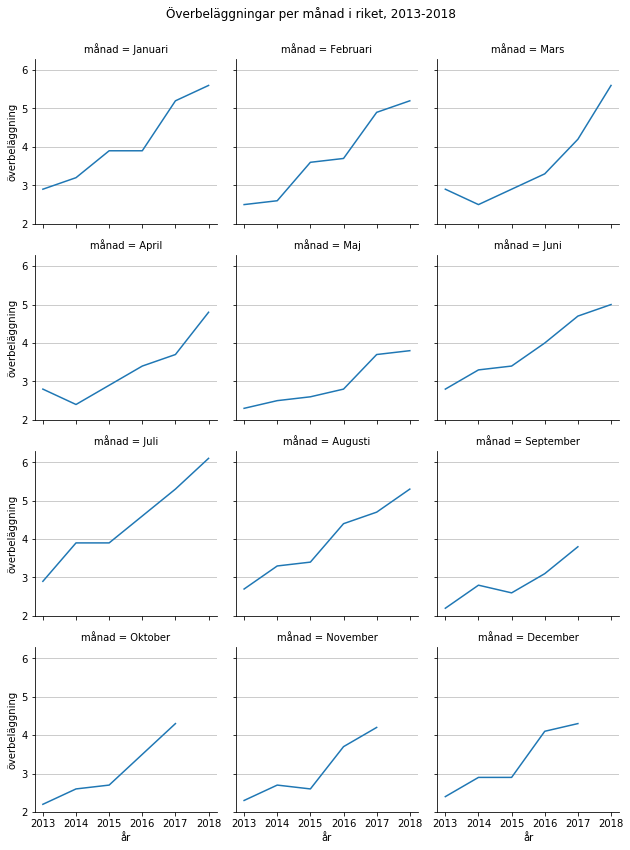

In [43]:
g = sns.FacetGrid(alla,col='månad',col_wrap=3)
g.map(plt.plot,'år','överbeläggning')


for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')

plt.subplots_adjust(top=0.92)
g.fig.suptitle('Överbeläggningar per månad i riket, 2013-2018')

plt.savefig('res/utveckling_per_månad_riket.png')

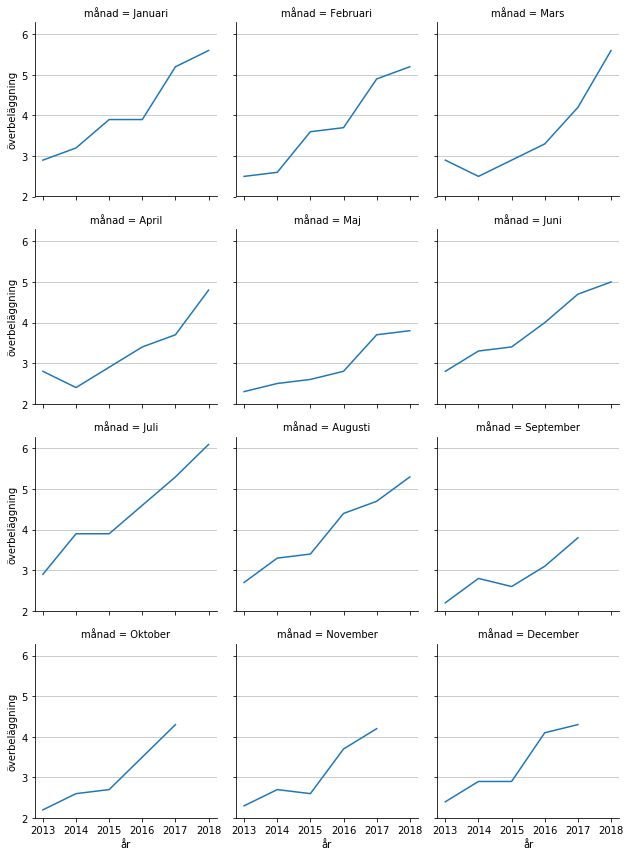

In [44]:
g = sns.FacetGrid(alla,col='månad',col_wrap=3)
g.map(plt.plot,'år','överbeläggning')

for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')
plt.savefig('res/utveckling_per_månad_riket.png')

#### Nu för samma grafsammanställning fast per landsting

Hämta data

In [47]:
df = pd.read_excel('data/överbeläggningar.xlsx',header=5)

basic df-formattering

In [48]:
df.columns

df.rename(columns={'Landsting / region':'landsting'},inplace=True)

df.columns = df.columns.str.lower().str.replace(" ","_")

df = df.sort_values('månad')

Bort med alla rader "Alla landsting"

In [49]:
df = df.loc[df['landsting']!='Alla landsting']

import datetime

df.rename(columns={'månad':'date'},inplace=True)

df['månad'] = df.date.apply(lambda x: x.strftime('%m'))

df['år'] = df.date.apply(lambda x: x.strftime('%Y'))

månader = {
    '01':'Januari',
    '02':'Februari',
    '03':'Mars',
    '04':'April',
    '05':'Maj',
    '06':'Juni',
    '07':'Juli',
    '08':'Augusti',
    '09':'September',
    '10':'Oktober',
    '11':'November',
    '12':'December'
}

df.månad=df.månad.map(månader)

I datat så har man över tid bytt namn på landstingen:

In [50]:
df.landsting.drop_duplicates()

1318                    Östergötland
1298                        Blekinge
1299                         Dalarna
1300                         Gotland
1301                       Gävleborg
1302                         Halland
1303             Jämtland Härjedalen
1304                       Jönköping
1305                          Kalmar
1306                       Kronoberg
1317                          Örebro
1308                           Skåne
1309                       Stockholm
1310                        Sörmland
1311                         Uppsala
1312                        Värmland
1313                    Västerbotten
1314                  Västernorrland
1315                     Västmanland
1316                 Västra Götaland
1307                      Norrbotten
314       Region Jämtland Härjedalen
329              Region Östergötland
309             Landstinget Blekinge
310              Landstinget Dalarna
311                   Region Gotland
312                 Region Gävleborg
3

Vi får därför stryka ord i namnen på landstingen för att få enhetliga rader:

In [51]:
import re

In [52]:
pattern = "Region|landsting|Landstinget|\si\s|läns*"

In [53]:
name= "Region Jönköpings län"

In [54]:
landstingsnamn = 'Stockholms|Västerbottens|Jönköpings'

In [55]:
def replacer(name,pattern=pattern,landstingsnamn=landstingsnamn):
    r = re.findall(pattern,name)
    for match in r:
        name = name.replace(match,"")
    r = re.findall(landstingsnamn,name)
    if r:
        for match in r:
            name = name.replace(match,match[:-1])
    return name.strip()

In [56]:
df.landsting=df.landsting.apply(lambda x: replacer(x,pattern))

In [57]:
df.loc[df['landsting']=='Västra Götalandsregionen','landsting'] = 'Västra Götaland'

In [58]:
len(df.landsting.unique())

21

Done!

Formattera fram en kolumn med endast månadernas namn:

In [59]:
jämförelsemånader = ['Januari', 'Februari', 'Mars', 'April', 'Maj', 'Juni', 'Juli', 'Augusti']

Filtrera bort de månader som inte finns för år 2018:

In [60]:
df = df.loc[df['månad'].isin(jämförelsemånader)]

Räkna ut årsmedel per landsting:

In [61]:
for year in df.år.unique():
    for län in df.landsting.unique():
        df.loc[(df['år']==year)&(df['landsting']==län),'medel'] = df.loc[(df['år']==year)&(df['landsting']==län),'överbeläggning'].mean()

In [62]:
landstingen = df[['landsting','år','medel']].drop_duplicates()

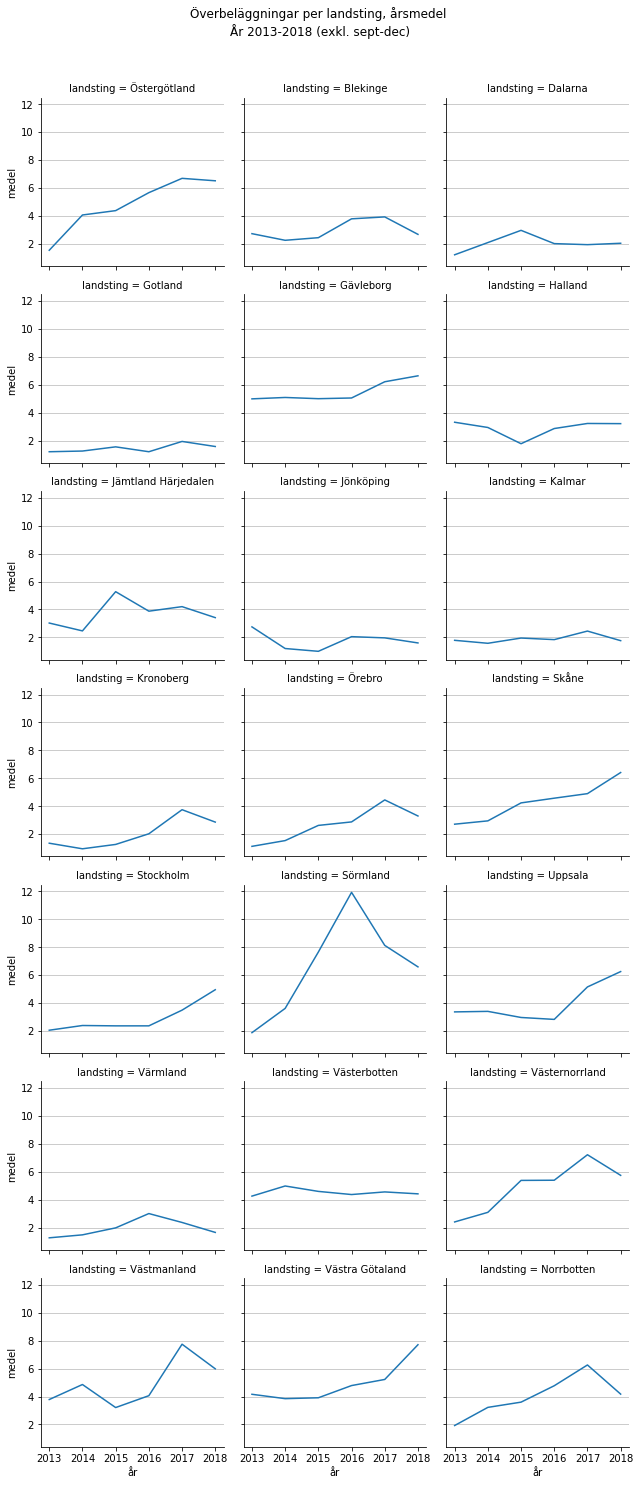

In [63]:
g = sns.FacetGrid(landstingen,col='landsting',col_wrap=3)
g.map(plt.plot,'år','medel')


for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')

plt.subplots_adjust(top=0.92)
g.fig.suptitle('Överbeläggningar per landsting, årsmedel \nÅr 2013-2018 (exkl. sept-dec)')

plt.savefig('res/utveckling_per_landsting.png')

In [ ]:
landstingen.pivot(index='landsting',columns='år',values='medel').reset_index().to_excel('res/per_landsting.xlsx',index=False)